## Setup

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from time import sleep
plt.style.use('bmh')

In [2]:
from result import *
from pyopencga.opencga_config import ClientConfiguration
from pyopencga.opencga_client import OpenCGAClient

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

## Configure and Connect

In [4]:
# User configuration will be read from a .env file
config = ClientConfiguration({
        "rest": {
                "host": os.environ.get("OPENCGA_HOST")
        }
})
oc = OpenCGAClient(config)

## User Login 

In [5]:
user = os.environ.get("OPENCGA_USERNAME")
passwd = os.environ.get("OPENCGA_PASSWORD")
oc.login(user, passwd) # 

### OpenCGA Clients

In [6]:
users = oc.users
projects = oc.projects
studies = oc.studies
files = oc.files
jobs = oc.jobs
families = oc.families
individuals = oc.individuals
samples = oc.samples
cohorts = oc.cohorts
panels = oc.panels

## Sample Queries

In [7]:
sample_result = oc.samples.search(study='1kG_phase3', limit=5)

We can of course use python to extract only the fields we care about

In [8]:
[res['id'] for res in sample_result.results()]

['HG00096', 'HG00097', 'HG00099', 'HG00100', 'HG00101']

## See available methods
We have only been using the "results" methods from result object but we can see what are the other available methods

In [9]:
help(sample_result)

Help on RESTResponse in module pyopencga.commons object:

class RESTResponse(builtins.object)
 |  RESTResponse(response)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, response)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  num_matches(self)
 |      Return the total number of matches taking of all the DataResponses
 |  
 |  num_results(self)
 |      Return the total number of results taking of all the DataResponses
 |  
 |  results(self)
 |      Iterates over all the results of all the QueryResults
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## Create Samples

In [10]:
# samples.create(data={"id":"A"})
# samples.create(data={"id":"B"})
# samples.create(data={"id":"C"})

## VariableSet annotations

We can add custom annotations to individuals, samples, cohorts, etc through the idea of *VariableSet* similar to a table but more flexible.You can add the annotations during the individual creation step or later through the *update* method. We have already created a variableset called samples_metadata to add custom annotaions to any sample

In [11]:
samples.update(query_id="A",data={"name":"A","annotationSets":
                                 [{"id":"demo1","variableSetId":"samples_metadata",
                                   "annotations":{"sample_id":"A","sample_batch":"1",
                                                  "volume":"52","amount":"1 g",
                                                  "fastqc_download_status":"Downloaded",
                                                  "date_processed_by_gsc":"07/06/2021"}}]},
               annotationSetsAction="SET")

In [12]:
samples.update(query_id="B",data={"name":"B","annotationSets":
                                 [{"id":"demo1","variableSetId":"samples_metadata",
                                   "annotations":{"sample_id":"B","sample_batch":"1",
                                                  "volume":"45","amount":"1 g",
                                                 "fastqc_download_status":"Downloaded",
                                                 "date_processed_by_gsc":"09/08/2021"}}]},
                annotationSetsAction="SET")

In [13]:
samples.update(query_id="C",data={"name":"C","annotationSets":
                                 [{"id":"demo1","variableSetId":"samples_metadata",
                                   "annotations":{"sample_id":"C","sample_batch":"1",
                                                  "volume":"48","amount":"1 g",                                                  
                                                  "fastqc_download_status":"Downloaded",
                                                 "date_processed_by_gsc":"09/09/2021"}}]},
              annotationSetsAction="SET")

#### we can use a single query to search multiple samples at once

In [14]:
res = samples.info(query_id = "A,B,C",study="1kG_phase3")
for sample in res.results():
    print(sample)

{'id': 'A', 'annotationSets': [{'id': 'demo1', 'name': 'demo1', 'variableSetId': 'samples_metadata', 'annotations': {'volume': '52', 'date_processed_by_gsc': '07/06/2021', 'amount': '1 g', 'fastqc_download_status': 'Downloaded', 'sample_id': 'A', 'sample_batch': '1'}, 'creationDate': '20220110075129', 'release': 1, 'attributes': {}}], 'name': 'A', 'uuid': 'V8PlhQF8AAQAAesh7nKstg', 'source': '', 'individual': {'release': 0, 'version': 0, 'parentalConsanguinity': False}, 'release': 1, 'version': 1, 'creationDate': '20211006224028', 'modificationDate': '20220110075129', 'status': {'name': 'READY', 'date': '20211006224028', 'message': ''}, 'description': '', 'type': '', 'somatic': False, 'phenotypes': [], 'stats': {}, 'attributes': {}}
{'id': 'B', 'annotationSets': [{'id': 'demo1', 'name': 'demo1', 'variableSetId': 'samples_metadata', 'annotations': {'volume': '45', 'date_processed_by_gsc': '09/08/2021', 'amount': '1 g', 'fastqc_download_status': 'Downloaded', 'sample_id': 'B', 'sample_bat

##### By default you only see a regular python dictionaries which might not be the best way to inspect the samples metadata

### We define a small function to get sample data

In [15]:
def get_sample_details(resp):
    if not resp['annotationSets']: 
        return Err("Not found")      
    res = resp['annotationSets'][0]['annotations']
    return Ok(res)

##### We can use our new function and get a nice dataframe

In [16]:
ds = [get_sample_details(r).unwrap_or('NA') for r in res.results()]
df = pd.DataFrame(ds)
df.head()

,volume,date_processed_by_gsc,amount,fastqc_download_status,sample_id,sample_batch
0,52,07/06/2021,1 g,Downloaded,A,1
1,45,09/08/2021,1 g,Downloaded,B,1
2,48,09/09/2021,1 g,Downloaded,C,1


##### Since we have a pandas dataframe we can use it to inspect the data and do some visualization after minor data preprocessing

In [17]:
df.date_processed_by_gsc = pd.to_datetime(df.date_processed_by_gsc)
df.volume = pd.to_numeric(df.volume)

In [18]:
df.head()

,volume,date_processed_by_gsc,amount,fastqc_download_status,sample_id,sample_batch
0,52,2021-07-06,1 g,Downloaded,A,1
1,45,2021-09-08,1 g,Downloaded,B,1
2,48,2021-09-09,1 g,Downloaded,C,1


### An example visualization

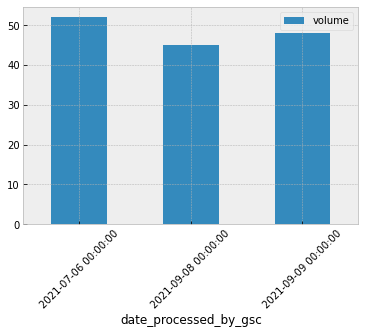

In [19]:
df.plot("date_processed_by_gsc","volume",kind="bar")
plt.xticks(rotation=45);

### Bulk Import of Sample Data from an Excel Sheet

So far we have seen an example how to import a single sample, however, it would be more convienent to import multiple samples at once. We can do that by reading a standard Excel sheet

![example sheet](excel.png)

In [20]:
sheet = pd.read_excel("samples metadata.xlsx",sheet_name="data")
sheet

,sample_id,sample_batch,sample_tissue,sample_provenance,volume,concentration,amount,quantification_method,date_shipment_gsc,date_received_by_gsc,date_qced_by_gsc,qc_by_gsc_result
0,A,1,blood,GSC,25,0.001,0.44,Illumina,2021-11-09,25/10/2021,2021-07-07,PASS
1,B,1,blood,GSC,25,0.001,0.50,Illumina,2021-11-09,25/10/2021,2021-12-08,PASS
2,C,1,blood,Alliance,24,0.001,0.52,Illumina,2021-11-09,25/10/2021,2021-11-10,PASS
3,D,1,blood,Alliance,23,0.001,0.39,Illumina,2021-11-09,25/10/2021,2021-12-10,PASS


after simple preprocessing

In [21]:
for col in sheet.columns:
    sheet[col] = sheet[col].astype('string')

we can load the sample data in one loop

In [22]:
for i in range(sheet.shape[0]):
    samples.update(query_id=sheet.sample_id[i],data={"name":sheet.sample_id[i],"annotationSets":
                                 [{"id":"demo2","variableSetId":"sample_metadata",
                                   "annotations":{"sample_id":sheet.sample_id[i],
                                                  "sample_batch":sheet.sample_batch[i],
                                                  "sample_tissue":sheet.sample_tissue[i],
                                                  "sample_provenance":sheet.sample_provenance[i],
                                                  "volume":sheet.volume[i],
                                                  "concentration":sheet.concentration[i],
                                                  "amount":sheet.amount[i],
                                                  "quantification_method":sheet.quantification_method[i],
                                                  "date_shipment_gsc":sheet.date_shipment_gsc[i],
                                                  "date_received_by_gsc":sheet.date_received_by_gsc[i],
                                                  "date_qced_by_gsc":sheet.date_qced_by_gsc[i],
                                                  "qc_by_gsc_result":sheet.qc_by_gsc_result[i]
                                                  }}]},
               annotationSetsAction="SET")
    sleep(0.05)

In [23]:
res = samples.info(query_id = "A,B,C,D",study="1kG_phase3")

In [24]:
ds = [get_sample_details(r).unwrap_or('NA') for r in res.results()]
df = pd.DataFrame(ds)
df.head()

,date_received_by_gsc,volume,amount,sample_provenance,qc_by_gsc_result,date_qced_by_gsc,sample_id,sample_tissue,date_shipment_gsc,concentration,sample_batch,quantification_method
0,25/10/2021,25,0.44,GSC,PASS,2021-07-07,A,blood,2021-11-09,0.001,1,Illumina
1,25/10/2021,25,0.5,GSC,PASS,2021-12-08,B,blood,2021-11-09,0.001,1,Illumina
2,25/10/2021,24,0.52,Alliance,PASS,2021-11-10,C,blood,2021-11-09,0.001,1,Illumina
3,25/10/2021,23,0.39,Alliance,PASS,2021-12-10,D,blood,2021-11-09,0.001,1,Illumina
